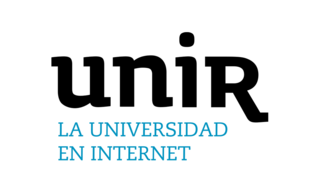

_Máster Universitario en Inteligencia Artificial_

_Trabajo Fin de Máster_

- Gustavo Mateos Santos
- gustavo.mateos830@comunidadunir.net

# Clasificación automática de estrellas variables con modelos Transformer aplicados a series temporales



In [ ]:
# Install missing packages
%pip install torch lightkurve
%pip install -q pyarrow

In [3]:
import torch, lightkurve as lk

print("Torch:", torch.__version__)
print("Lightkurve:", lk.__version__)

Torch: 2.2.2
Lightkurve: 2.5.0


## **Fase 2: Diseño e Implementación del Modelo Transformer**



## **NUEVO CICLO DE ENTRENAMIENTO+FINE-TUNING DESPUES DE REDUCIR A 7 CLASES (MEJOR MODELO HASTA AHORA) Y REFORZAR DATASET CON ERRORES DE CLASIFICACION (YSO)**

Último ciclo de pruebas: después de llegar al mejor modelo en `astro_transformer_fase2_sagemaker.ipynb`, se analizaron los errores de clasificación del modelo y se vio que la clase YSO, aun siendo ahora la mayoritaria en el dataset, generaba muchos falsos positivos (clase predicha YSO pero otra clase real) y también un buen número de falsos negativos (otras clases que el modelo confundía y predecía como YSO). 

En el notebook `16_preprocesado_YSO_review.ipynb` se generaron los datasets con IDs de objeto, así como CSVs de errores de clasificación, también con IDs de objeto. Cruzando todo ello se concluyó:

- 🔍 Total de FALSOS NEGATIVOS (YSO reales pero no predichas): **430**
- 🔍 Total de FALSOS POSITIVOS (YSO predichas pero no reales): **858**
- 🔍 Total de curvas a eliminar: 1288

Motivo_descarte
YSO predicha incorrectamente (FP)    858
YSO mal clasificada (FN)             430

📊 **Curvas confusas**. Desglose por clase original (impacto en dataset):

| Clase                | Nº curvas |
| -------------------- | --------- |
| Young Stellar Object | 430     |
| Eclipsing Binary     | 238     |
| Cataclysmic          | 195     |
| Rotational           | 170     |
| Delta Scuti          | 101     |
| RR Lyrae             | 97     |
| Irregular            | 57     |

✅ Guardado en: ../data/train/curvas_a_eliminar_por_confusion_yso.csv

La idea es hacer un nuevo preprocesado + training + fine tuning, en el que los datasets se van a generar nuevos pero filtrando las clases de manera que se eliminen las curvas identificadas como dudosas o confusas: 

- 📂 [INFO] IDs a excluir por filtrado: 1288
- 📂 [INFO] Exclusiones por clase: {'Cataclysmic': 195, 'Delta Scuti': 97, 'Eclipsing Binary': 238, 'Irregular': 57, 'RR Lyrae': 101, 'Rotational': 170, 'Young Stellar Object': 430}

#### 1. **PREPROCESADO**

In [1]:
import warnings
import numpy as np
import sys
from pathlib import Path

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

# Ignorar solo los RuntimeWarning de numpy (como overflows en reduce)
warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy")

from src.fase2.script_1_transformer_preprocessing_optimizado_2 import main as preprocessing_optimized_YSO_cleaning

# Balanceo de clases 
max_per_class_override={
    "Irregular": 9000,
    "Rotational": 9000,
    "Eclipsing Binary": 9000,
    "Delta Scuti": None,            # 7.550 → TODAS
    "RR Lyrae": 9000,               # 41.208 → RECORTAMOS A 9.000
    "Young Stellar Object": None,   # 9.809 → TODAS 
    "Cataclysmic": None,            # 2.080 → TODAS
    "White Dwarf": 0,               # 0 → LA ELIMINAMOS
    "Variable": 0                   # 0 → LA ELIMINAMOS
}

# El script se ha adaptado para filtrar curvas malas directamente con el parametro `filtrar_curvas_malas`
preprocessing_optimized_YSO_cleaning(
    seq_length=25000,
    max_per_class=None, # usamos override completo
    max_per_class_override=max_per_class_override,
    parquet_batch_size=10_000_000,
    dataloader_batch_size=128,
    num_workers=20,
    filtrar_curvas_malas="../data/train/curvas_a_eliminar_por_confusion_yso.csv"
    #errores_csv_path=Path("../outputs/errores_mal_clasificados.csv")
)

📂 Cargando datos en lotes con PyArrow...
📂 [INFO] IDs a excluir por filtrado: 1288
📂 [INFO] Exclusiones por clase: {'Cataclysmic': 195, 'Delta Scuti': 97, 'Eclipsing Binary': 238, 'Irregular': 57, 'RR Lyrae': 101, 'Rotational': 170, 'Young Stellar Object': 430}
💾 [INFO] Cargando agrupación de curvas desde cache: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../data/train/grouped_data.pkl
✅ [INFO] Agrupación cargada desde cache. Total objetos: 54947
⏳ [INFO] Tiempo en agrupación de datos: 248.9 segundos
🚀 Procesando 54947 curvas en paralelo usando 20 CPUs...
⏳ [INFO] Tiempo en procesamiento paralelo: 82.1 segundos
🔋 [INFO] Curvas válidas tras filtrado: 54854
🔎 Ejemplos aleatorios después del filtrado final:
ID: ASASSN-V J031510.38+545659.0, Clase: Rotational
ID: ASASSN-V J051539.55-611420.1, Clase: Cataclysmic
ID: ASASSN-V J025201.04-233827.4, Clase: Irregular
ID: ASASSN-V J153259.00-332342.9, Clase: RR Lyrae
ID: ASASSN-V J073526.05-305037.0, Clase: Delta Scuti

🔍 Realizando p

(<torch.utils.data.dataloader.DataLoader at 0x7f526eab2b90>,
 <torch.utils.data.dataloader.DataLoader at 0x7f526eab3f10>)


#### Nueva distribución de clases tras preprocesado:


| Cod. | Clase                | Nº curvas |
| ---- | -------------------- | --------- |
| 0    | Cataclysmic          | **2.027**     |
| 1    | Delta Scuti          | **7.279**     |
| 2    | Eclipsing Binary     | **9.000**     |
| 3    | Irregular            | **9.000**     |
| 4    | RR Lyrae             | **9.000**     |
| 5    | Rotational           | **9.000**     |
| 6    | Young Stellar Object | **9.548**    |
|      | TOTAL                | **54.854** |

### **Verificaciones...**

In [1]:
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.serialization
from torch.utils.data import DataLoader
import sys
import gc
import os
import argparse
import warnings
from pathlib import Path

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

# Ignorar solo los RuntimeWarning de numpy (como overflows en reduce)
warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy")

from src.fase2.script_2_transformer_fine_tuning_optimizado import AstroConformerClassifier as AstroConformerClassifier, evaluate

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# acciones para resolver los problemas de memoria
# 1. Liberar memoria
gc.collect()
torch.cuda.empty_cache()

# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.backends.cudnn.benchmark = True

def detectar_todos_los_errores(preds, true, ids, label_encoder):
    """
    Retorna un DataFrame con todos los errores de clasificación con clase real y predicha bien decodificadas.
    """
    df_labels = pd.DataFrame({
        "id_objeto": ids,
        "true_label": true,
        "pred_label": preds
    })

    # Decodificar nombres
    label_decoder = {v: k for k, v in label_encoder.items()}
    df_labels["clase_real"] = df_labels["true_label"].map(label_decoder)
    df_labels["clase_predicha"] = df_labels["pred_label"].map(label_decoder)

    # Filtrar errores
    df_errores = df_labels[df_labels["clase_real"] != df_labels["clase_predicha"]][
        ["id_objeto", "clase_real", "clase_predicha"]
    ].reset_index(drop=True)

    return df_errores

def detectar_yso_confundidas(preds, true, ids, label_encoder):
    """
    Retorna un DataFrame con los objetos cuya clase fue predicha como YSO pero no lo eran.
    """
    df_labels = pd.DataFrame({
        "id_objeto": ids,
        "true_label": true,
        "pred_label": preds
    })

    label_decoder = {v: k for k, v in label_encoder.items()}
    df_labels["clase_real"] = df_labels["true_label"].map(label_decoder)
    df_labels["clase_predicha"] = df_labels["pred_label"].map(label_decoder)

    df_yso_mal = df_labels[
        (df_labels["clase_predicha"] == "Young Stellar Object") &
        (df_labels["clase_real"] != "Young Stellar Object")
    ][["id_objeto", "clase_real", "clase_predicha"]].reset_index(drop=True)

    return df_yso_mal


# Cargar dataset y label encoder
from src.fase2.script_1_transformer_preprocessing_optimizado_2 import LightCurveDataset
#torch.serialization.add_safe_globals([LightCurveDataset])

val_dataset = torch.load("../data/train/val_dataset.pt", weights_only=False)

# Verificacion rapida
# Cargar un sample cualquiera
sample = val_dataset[0]
# Ver cuántos elementos contiene
print("Nº de elementos devueltos por __getitem__:", len(sample))
# Inspeccionar los elementos
for i, item in enumerate(sample):
    print(f"Elemento {i}: {type(item)}, shape o valor: {getattr(item, 'shape', item)}")

with open("../data/train/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)
num_classes = len(label_encoder)
class_names = list(label_encoder.keys())

# Dataloader con batch pequeño
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=6, pin_memory=True, persistent_workers=True)

# Crear el modelo con la arquitectura esperada
args = argparse.Namespace(
    input_dim=1,
    in_channels=1,
    encoder_dim=256,
    hidden_dim=384,
    output_dim=num_classes,
    num_heads=8,
    num_layers=8,
    dropout=0.4, dropout_p=0.4,
    stride=32,
    kernel_size=3,
    norm="postnorm",
    encoder=["mhsa_pro", "conv", "conv"],
    timeshift=False,
    device=device
)
model = AstroConformerClassifier(args, num_classes=len(label_encoder), feature_dim=7)

# Cargar los pesos entrenados
state_dict = torch.load("../outputs/mejor_modelo_finetuned_optimizado2_features_segunda_vuelta.pt", map_location="cpu")
# Elimina el prefijo "_orig_mod." de las claves
new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
model.load_state_dict(new_state_dict)

# Pasar a GPU si está disponible
model = model.to(device)
model.eval()  # Muy importante: modo evaluación

criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluar con IDs
val_loss, preds, true, ids = evaluate(model, val_loader, criterion, device)

#####################################
# Mostrar el label encoder para asegurar consistencia (opcional si ya lo hiciste)
print("Contenido del label encoder:")
for key, value in label_encoder.items():
    print(f"{key}: {value}")
# Mapear IDs a clases reales desde el CSV original
df_debug = pd.read_csv("../data/train/debug_clases_codificadas.csv")
dict_clases_reales = dict(zip(df_debug["id"].astype(str), df_debug["clase_variable"]))
print("\n🔍 Verificación manual de los primeros errores:")
for i in range(5):
    pred_label = class_names[preds[i]]
    true_label = class_names[true[i]]
    object_id = str(ids[i])

    real_ref = dict_clases_reales.get(object_id, "NO_ENCONTRADO")

    print(f"ID: {object_id}")
    print(f" - Predicha: {pred_label}")
    print(f" - Real (según modelo): {true_label}")
    print(f" - Real (en CSV original): {real_ref}")
    print("---")
#####################################

# Detectar YSO mal clasificadas
df_yso_mal = detectar_yso_confundidas(preds, true, ids, label_encoder)
df_yso_mal.to_csv("../outputs/yso_clase_predicha_error2.csv", index=False)
# Detectar todos los errores
df_todos_errores = detectar_todos_los_errores(preds, true, ids, label_encoder)
df_todos_errores.to_csv("../outputs/todos_los_errores2.csv", index=False)

print(f"YSOs mal clasificadas detectadas: {len(df_yso_mal)}")
print(f"Total de errores detectados: {len(df_todos_errores)}")


Matplotlib is building the font cache; this may take a moment.


Nº de elementos devueltos por __getitem__: 5
Elemento 0: <class 'torch.Tensor'>, shape o valor: torch.Size([25000])
Elemento 1: <class 'torch.Tensor'>, shape o valor: torch.Size([])
Elemento 2: <class 'torch.Tensor'>, shape o valor: torch.Size([25000])
Elemento 3: <class 'torch.Tensor'>, shape o valor: torch.Size([7])
Elemento 4: <class 'str'>, shape o valor: ASASSN-V J024446.27+065612.3
Contenido del label encoder:
Cataclysmic: 0
Delta Scuti: 1
Eclipsing Binary: 2
Irregular: 3
RR Lyrae: 4
Rotational: 5
Young Stellar Object: 6

🔍 Verificación manual de los primeros errores:
ID: ASASSN-V J024446.27+065612.3
 - Predicha: Young Stellar Object
 - Real (según modelo): Young Stellar Object
 - Real (en CSV original): Young Stellar Object
---
ID: ASASSN-V J010244.04+562906.6
 - Predicha: Irregular
 - Real (según modelo): Irregular
 - Real (en CSV original): Irregular
---
ID: ASASSN-V J040748.13+452112.9
 - Predicha: Eclipsing Binary
 - Real (según modelo): Eclipsing Binary
 - Real (en CSV orig

In [2]:
# Ejemplo para comprobar el contenido de un dataset .pt
import torch
import sys
from pathlib import Path

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
    
# Cargar el dataset (ajusta la ruta si es necesario)
dataset = torch.load("../data/train/train_dataset.pt", weights_only=False)

# Obtener el primer elemento
sample = dataset[0]

# Mostrar información de cada campo
for i, value in enumerate(sample):
    print(f"Elemento {i}: tipo={type(value)}, valor/shape={getattr(value, 'shape', value)}")

# Ejemplo de salida esperada:
# Elemento 0: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([25000])
# Elemento 1: tipo=<class 'torch.Tensor'>, valor/shape=tensor(3)
# Elemento 2: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([25000])
# Elemento 3: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([7])
# Elemento 4: tipo=<class 'str'>, valor/shape=ASASSN-V J055358.70+014409.5

Elemento 0: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([25000])
Elemento 1: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([])
Elemento 2: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([25000])
Elemento 3: tipo=<class 'torch.Tensor'>, valor/shape=torch.Size([7])
Elemento 4: tipo=<class 'str'>, valor/shape=ASASSN-V J062458.42-352355.1


In [2]:
import pandas as pd

# Cargar ambos archivos
df_errores = pd.read_csv("../outputs/todos_los_errores2.csv")
df_ref = pd.read_csv("../data/train/debug_clases_codificadas.csv")

# Renombrar para evitar conflictos
df_ref = df_ref.rename(columns={"id": "id_objeto", "clase_variable": "clase_real_ref"})

# ⚠️ Filtrar solo errores cuyos IDs aún están en el dataset final
df_errores_filtrados = df_errores[df_errores["id_objeto"].isin(df_ref["id_objeto"])].copy()

# Cruzar por ID
df_merge = pd.merge(df_errores_filtrados, df_ref, on="id_objeto", how="left")

# Verificar discrepancias REALES
df_discrepancias = df_merge[df_merge["clase_real"] != df_merge["clase_real_ref"]]

# Mostrar resumen
print(f"🔎 Total errores analizados: {len(df_errores_filtrados)} (de {len(df_errores)} totales)")
print(f"❌ Discrepancias reales: {len(df_discrepancias)}")
if not df_discrepancias.empty:
    print(df_discrepancias.head(10))


🔎 Total errores analizados: 2298 (de 2298 totales)
❌ Discrepancias reales: 0


In [6]:
import torch

# Cargar dataset
val_dataset = torch.load("../data/train/val_dataset.pt", weights_only=False)

# Elegir IDs concretos con discrepancias
ids_problema = [
    "ASASSN-V J024305.65-065501.3",
    "ASASSN-V J031438.40+581303.1",
    "ASASSN-V J093207.60-823329.8",
    "ASASSN-V J114016.78+184126.4",
    "459672",
    "ASASSN-V J002142.23-414002.5",
    "ASASSN-V J112416.67-110645.0",
    "ASASSN-V J032732.09+000351.4",
    "ASASSN-V J030537.58-593637.3",
    "AP43491782",
    "ASASSN-V J031510.38+545659.0",  # Clase: Rotational
    "ASASSN-V J051539.55-611420.1",  # Clase: Cataclysmic
    "ASASSN-V J025201.04-233827.4",  # Clase: Irregular
    "ASASSN-V J153259.00-332342.9",  # Clase: RR Lyrae
    "ASASSN-V J073526.05-305037.0"   # Clase: Delta Scuti
]
# Cargar CSV codificado
df_codificadas = pd.read_csv("../data/train/debug_clases_codificadas.csv")
df_codificadas = df_codificadas.set_index("id")

# Cargar encoder
import pickle
with open("../data/train/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)
inv_label_encoder = {v: k for k, v in label_encoder.items()}

# Buscar en val_dataset los objetos y verificar su label real
print("🔍 Verificación directa en dataset:")
for i in range(len(val_dataset)):
    _, label, _, _, id_obj = val_dataset[i]
    if id_obj in ids_problema:
        clase_real_dataset = inv_label_encoder[label.item()]
        clase_codificada_csv = df_codificadas.loc[id_obj, "clase_codificada"]
        clase_nombre_csv = df_codificadas.loc[id_obj, "clase_variable"]
        print(f"🧾 ID: {id_obj}")
        print(f" - Clase val_dataset: {clase_real_dataset}")
        print(f" - Clase CSV codificado: {clase_nombre_csv} ({clase_codificada_csv})")
        print("---")


🔍 Verificación directa en dataset:
🧾 ID: ASASSN-V J032732.09+000351.4
 - Clase val_dataset: Eclipsing Binary
 - Clase CSV codificado: Eclipsing Binary (2)
---
🧾 ID: AP43491782
 - Clase val_dataset: Rotational
 - Clase CSV codificado: Rotational (5)
---
🧾 ID: ASASSN-V J051539.55-611420.1
 - Clase val_dataset: Cataclysmic
 - Clase CSV codificado: Cataclysmic (0)
---
🧾 ID: ASASSN-V J030537.58-593637.3
 - Clase val_dataset: Delta Scuti
 - Clase CSV codificado: Delta Scuti (1)
---
🧾 ID: ASASSN-V J002142.23-414002.5
 - Clase val_dataset: Delta Scuti
 - Clase CSV codificado: Delta Scuti (1)
---
🧾 ID: ASASSN-V J153259.00-332342.9
 - Clase val_dataset: RR Lyrae
 - Clase CSV codificado: RR Lyrae (4)
---
🧾 ID: ASASSN-V J031510.38+545659.0
 - Clase val_dataset: Rotational
 - Clase CSV codificado: Rotational (5)
---
🧾 ID: ASASSN-V J112416.67-110645.0
 - Clase val_dataset: RR Lyrae
 - Clase CSV codificado: RR Lyrae (4)
---
🧾 ID: ASASSN-V J114016.78+184126.4
 - Clase val_dataset: Delta Scuti
 - Clase

### 2. **ENTRENAMIENTO**

Matplotlib is building the font cache; this may take a moment.


🔄 Restaurando datasets...
✅ Dataset cargado en 978.36 segundos
🔄 Cargando datasets completos...
Total batches in train_loader: 200
Total batches in val_loader: 58
✅ Comprobación completada
TOTAL CLASES: 7
🚀 Entrenando modelo optimizado...
AstroConformerClassifier(
  (encoder): Astroconformer(
    (extractor): Sequential(
      (0): Conv1d(1, 256, kernel_size=(32,), stride=(32,))
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
    (pe): RotaryEmbedding()
    (encoder): ConformerEncoder(
      (blocks): ModuleList(
        (0-7): 8 x ConformerBlock(
          (modlist): ModuleList(
            (0): PostNorm(
              (module): MHA_rotary(
                (query): Linear(in_features=256, out_features=256, bias=True)
                (key): Linear(in_features=256, out_features=256, bias=True)
                (value): Linear(in_features=256, out_features=256, bias=True)
                (rotary_emb): RotaryEmbedding()
  

Entrenamiento del modelo:   0%|          | 0/50 [00:00<?, ?it/s]

[TRAIN] TIEMPO ÉPOCA: 163.3686s
[VAL] TIEMPO ÉPOCA: 40.8605s

🧪 Epoch 1/50
Train loss: 1.9277, Val loss: 1.7994
Train acc: 0.2296, Val acc: 0.3854
💾 Guardado modelo mejorado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated.pt
[TRAIN] TIEMPO ÉPOCA: 137.2942s
[VAL] TIEMPO ÉPOCA: 39.8972s

🧪 Epoch 2/50
Train loss: 1.7685, Val loss: 1.6575
Train acc: 0.3579, Val acc: 0.4559
💾 Guardado modelo mejorado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated.pt
[TRAIN] TIEMPO ÉPOCA: 137.2534s
[VAL] TIEMPO ÉPOCA: 39.9007s

🧪 Epoch 3/50
Train loss: 1.6729, Val loss: 1.5662
Train acc: 0.4147, Val acc: 0.4742
💾 Guardado modelo mejorado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated.pt
[TRAIN] TIEMPO ÉPOCA: 137.2035s
[VAL] TIEMPO ÉPOCA: 39.9750s

🧪 Epoch 4/50
Train loss: 1.6040, Val loss: 1.5066
Train acc: 0.4366, Val acc: 0.4844
💾 Gu

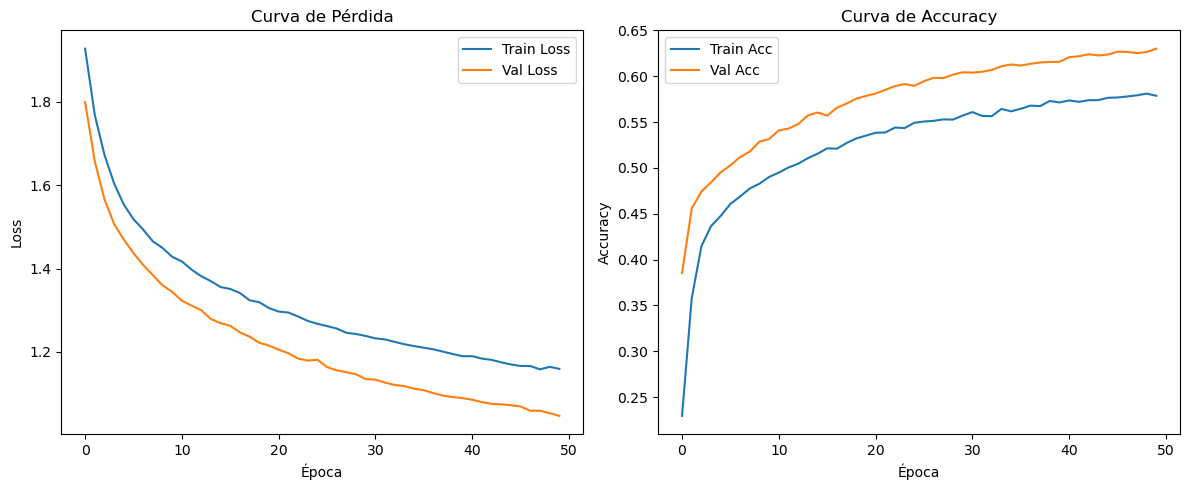


📊 Classification Report:
{'0': {'precision': 0.2588774341351661, 'recall': 0.5580246913580247, 'f1-score': 0.3536776212832551, 'support': 405.0}, '1': {'precision': 0.6599221789883268, 'recall': 0.5824175824175825, 'f1-score': 0.6187522801897117, 'support': 1456.0}, '2': {'precision': 0.6857457347275729, 'recall': 0.6922222222222222, 'f1-score': 0.6889687586397567, 'support': 1800.0}, '3': {'precision': 0.712832108535896, 'recall': 0.7005555555555556, 'f1-score': 0.7066405155505744, 'support': 1800.0}, '4': {'precision': 0.7898763978811065, 'recall': 0.7455555555555555, 'f1-score': 0.7670763075164333, 'support': 1800.0}, '5': {'precision': 0.6528599605522682, 'recall': 0.5516666666666666, 'f1-score': 0.5980126467931346, 'support': 1800.0}, '6': {'precision': 0.4965104685942173, 'recall': 0.5217391304347826, 'f1-score': 0.5088122605363985, 'support': 1909.0}, 'accuracy': 0.6300820419325432, 'macro avg': {'precision': 0.6080891833449363, 'recall': 0.6217402006014842, 'f1-score': 0.60599

In [1]:
import sys
import torch
import pickle
from torch.utils.data import DataLoader
from pathlib import Path
import time
import os
import gc

gc.collect()
torch.cuda.empty_cache()
# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_training_optimizado2 import main as train_model_optimized_YSO_cleaning

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

print("🔄 Restaurando datasets...")
start = time.time()
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")
print(f"✅ Dataset cargado en {time.time() - start:.2f} segundos")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=192, shuffle=True, num_workers=10, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=192, shuffle=False, num_workers=10, pin_memory=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

######################################################################
# Crear un mini-dataloader con batch pequeño para inspección
batch_size = 256
debug_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
for i, (x, y, mask, features, ids) in enumerate(debug_loader):
    if i >= 100:
        break
    # Validaciones de tipo
    if not torch.is_tensor(x) or not torch.is_tensor(mask):
        print(f"❌ No tensor en entrada en batch {i}")
    if not torch.is_tensor(y) or not torch.is_tensor(features):
        print(f"❌ y o features no son tensores en batch {i}")
    # Validaciones de contenido
    if not torch.isfinite(x).all():
        print(f"⚠️ x contiene NaN o Inf en batch {i}")
    if not torch.isfinite(mask).all():
        print(f"⚠️ mask contiene NaN o Inf en batch {i}")
    if not torch.isfinite(features).all():
        print(f"⚠️ features contiene NaN o Inf en batch {i}:\n{features}")
    # Validación de forma
    if features.shape[1] != 7:
        print(f"❌ Tamaño inesperado en features en batch {i}: {features.shape}")
    if x.shape != mask.shape:
        print(f"❌ Tamaños incompatibles en batch {i}: x {x.shape}, mask {mask.shape}")
    # Validación de etiquetas
    for j, label in enumerate(y):
        if not isinstance(label.item(), int):
            print(f"❌ Etiqueta no entera en batch {i}, elemento {j}: {label}")
        if label.item() < 0 or label.item() >= 9:
            print(f"❌ Etiqueta fuera de rango en batch {i}, elemento {j}: {label.item()}")
print("✅ Comprobación completada")
######################################################################

# Calcular número de clases
label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"TOTAL CLASES: {num_classes}")

# Ejecutar entrenamiento optimizado: 
# Ponderación por clase con class_weight
# dropout=0.3
# Scheduler ReduceLROnPlateau
# Early stopping
# Curvas de pérdida y accuracy
print("🚀 Entrenando modelo optimizado...")
model = train_model_optimized_YSO_cleaning(
    train_loader=train_loader,
    val_loader=val_loader,
    label_encoder=label_encoder,
    device=device,
    epochs=50,
    lr=3e-5,
    freeze_encoder=True,  # transfer learning clásico
    patience=6,           # early stopping
    debug=False,          # True para depuración
    model_name="mejor_modelo_optimizado_YSO_curated.pt"  # Nuevo argumento opcional
)

### 3. **FINE TUNING 1/2**

🔄 Restaurando datasets...
🔄 Cargando datasets completos...
Total batches in train_loader: 600
Total batches in val_loader: 172
NUM CLASES: 7
🚀 Fine-tuning sobre mejor modelo optimizado...
✅ Modelo base cargado desde /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated.pt
Modelo en: cuda:0


Fine-tuning:   0%|          | 0/40 [00:00<?, ?it/s]

⏱️ Tiempo entrenamiento: 233.45s
🔍 Tiempo evaluación: 46.46s

🧪 Epoch 1/40
Train loss: 1.1658, Val loss: 0.9926
Train acc: 0.5768, Val acc: 0.6490
💾 Guardado mejor modelo fine-tuned en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned.pt
⏱️ Tiempo época: 279.96s
🔓 Encoder descongelado y optimizador actualizado en epoch 2
⏱️ Tiempo entrenamiento: 91.57s
🔍 Tiempo evaluación: 27.10s

🧪 Epoch 2/40
Train loss: 1.1427, Val loss: 0.9884
Train acc: 0.5813, Val acc: 0.6462
💾 Guardado mejor modelo fine-tuned en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned.pt
⏱️ Tiempo época: 118.75s
⏱️ Tiempo entrenamiento: 91.56s
🔍 Tiempo evaluación: 27.08s

🧪 Epoch 3/40
Train loss: 1.1244, Val loss: 1.0233
Train acc: 0.5913, Val acc: 0.6325
⏱️ Tiempo época: 118.64s
⏱️ Tiempo entrenamiento: 91.69s
🔍 Tiempo evaluación: 27.09s

🧪 Epoch 4/40
Train loss: 1.1194, Val loss: 0.9895
Train

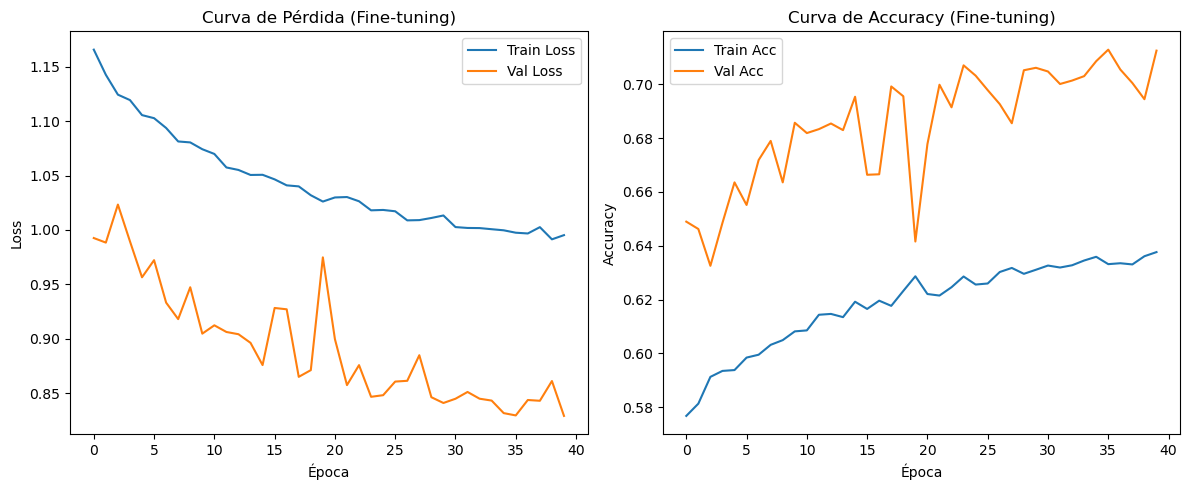

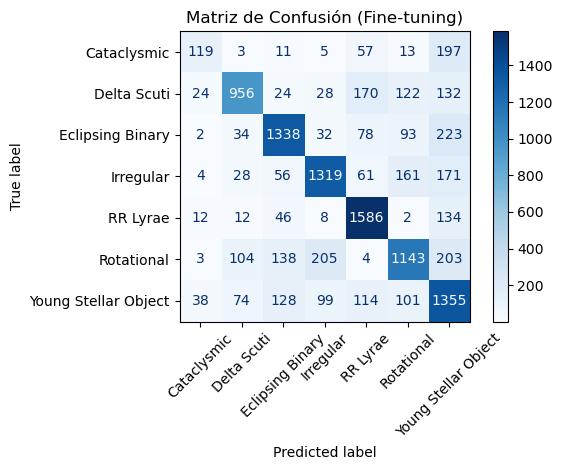

💾 Guardado CSV con errores: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_errores_clasificacion.csv
📄 Reporte de clasificación guardado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_class_report.csv
⚠️ Detected _orig_mod. prefix in state_dict. Stripping prefixes...


/home/ec2-user/SageMaker/astro_transformer/Astroconformer/Astroconformer/Model/Modules/mhsa_pro.py:108: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  cos, sin = RoPE
/home/ec2-user/SageMaker/astro_transformer/Astroconformer/Astroconformer/Model/Modules/mhsa_pro.py:113: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))                 # self-attention: (B, nh, T, hs) * (B, nh, hs, T) -> (B, nh, T, T)


✅ Modelo exportado a ONNX en: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned.onnx


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/onnx/utils.py:1703: UserWarning: The exported ONNX model failed ONNX shape inference. The model will not be executable by the ONNX Runtime. If this is unintended and you believe there is a bug, please report an issue at https://github.com/pytorch/pytorch/issues. Error reported by strict ONNX shape inference: [ShapeInferenceError] (op_type:Einsum, node name: /pe/Einsum): Inputs has inconsistent type tensor(float) (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/torch/csrc/jit/serialization/export.cpp:1484.)
  _C._check_onnx_proto(proto)


In [1]:
import torch
from torch.utils.data import DataLoader
import pickle
import os
import torch, gc
import sys
from pathlib import Path
import numpy as np

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_fine_tuning_optimizado import main as fine_tuned_optimized_model

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# acciones para resolver los problemas de memoria
# 1. Liberar memoria
gc.collect()
torch.cuda.empty_cache()

# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.backends.cudnn.benchmark = True

print("🔄 Restaurando datasets...")
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=12, pin_memory=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"NUM CLASES: {num_classes}")

# Fine-tuning optimizado
# Carga desde mejor_modelo_optimizado.pt
# Doble learning rate (encoder / head)
# Descongelado tras las primeras n epocas (freeze_epochs=n) o desde el principio (con freeze_encoder=False)
# label_smoothing=0.1 para mejorar la generalización (lo hemos quitado en esta prueba)
# Optimización por AdamW con weight_decay.
print("🚀 Fine-tuning sobre mejor modelo optimizado...")
model = fine_tuned_optimized_model(
    train_loader=train_loader,
    val_loader=val_loader,
    label_encoder=label_encoder,
    model_name_in="mejor_modelo_optimizado_YSO_curated.pt",  # El que se ha generado en el entrenamiento anterior
    model_name_out=None,  # Lo guarda como {model_name_in}_fine_tuned.pt, se le pasará al fine tuning siguiente
    device=device,
    epochs=40,
    patience=5,
    # freeze_encoder=False,
    freeze_epochs=2,
    encoder_lr=3e-6,
    head_lr=1e-4,  # Para acelerar la adaptación de la capa final
    gamma=3,
    use_scheduler=True,  # Usar scheduler ReduceLROnPlateau
)

### 4. **FINE TUNING 2/2**

Matplotlib is building the font cache; this may take a moment.


🔄 Restaurando datasets...
🔄 Cargando datasets completos...
Total batches in train_loader: 800
Total batches in val_loader: 229
NUM CLASES: 7
🚀 Fine-tuning sobre mejor modelo optimizado...
⚠️ Detected _orig_mod. prefix in state_dict. Stripping prefixes...
✅ Modelo base cargado desde /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned.pt
Modelo en: cuda:0


Fine-tuning:   0%|          | 0/15 [00:00<?, ?it/s]

⏱️ Tiempo entrenamiento: 601.66s
🔍 Tiempo evaluación: 54.77s

🧪 Epoch 1/15
Train loss: 0.9354, Val loss: 0.7551
Train acc: 0.6596, Val acc: 0.7304
💾 Guardado mejor modelo fine-tuned en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_2.pt
⏱️ Tiempo época: 656.48s
⏱️ Tiempo entrenamiento: 317.51s
🔍 Tiempo evaluación: 25.20s

🧪 Epoch 2/15
Train loss: 0.8671, Val loss: 0.7377
Train acc: 0.6851, Val acc: 0.7380
💾 Guardado mejor modelo fine-tuned en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_2.pt
⏱️ Tiempo época: 342.80s
⏱️ Tiempo entrenamiento: 317.60s
🔍 Tiempo evaluación: 25.21s

🧪 Epoch 3/15
Train loss: 0.8326, Val loss: 0.6977
Train acc: 0.6978, Val acc: 0.7535
💾 Guardado mejor modelo fine-tuned en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_2.pt
⏱️ Tiempo época: 342.90s
⏱️ Tiempo ent

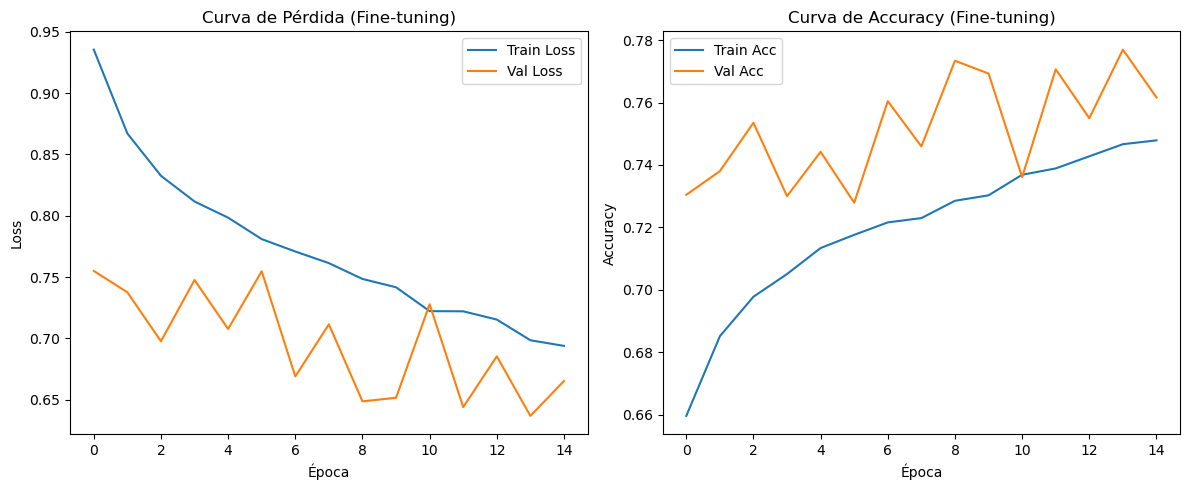

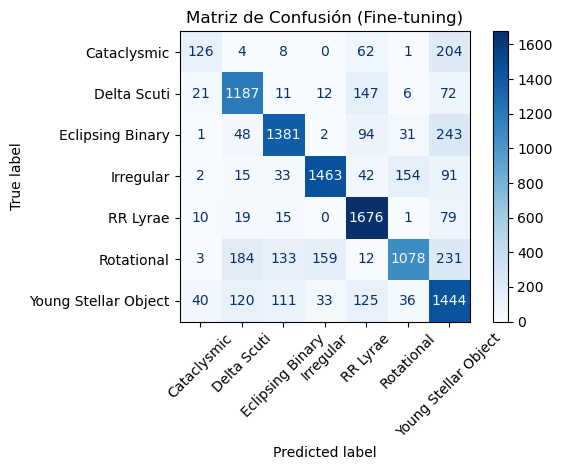

💾 Guardado CSV con errores: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_2_errores_clasificacion.csv
📄 Reporte de clasificación guardado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_2_class_report.csv
⚠️ Detected _orig_mod. prefix in state_dict. Stripping prefixes...


/home/ec2-user/SageMaker/astro_transformer/Astroconformer/Astroconformer/Model/Modules/mhsa_pro.py:108: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  cos, sin = RoPE
/home/ec2-user/SageMaker/astro_transformer/Astroconformer/Astroconformer/Model/Modules/mhsa_pro.py:113: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))                 # self-attention: (B, nh, T, hs) * (B, nh, hs, T) -> (B, nh, T, T)


✅ Modelo exportado a ONNX en: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_2.onnx


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/onnx/utils.py:1703: UserWarning: The exported ONNX model failed ONNX shape inference. The model will not be executable by the ONNX Runtime. If this is unintended and you believe there is a bug, please report an issue at https://github.com/pytorch/pytorch/issues. Error reported by strict ONNX shape inference: [ShapeInferenceError] (op_type:Einsum, node name: /pe/Einsum): Inputs has inconsistent type tensor(float) (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/torch/csrc/jit/serialization/export.cpp:1484.)
  _C._check_onnx_proto(proto)


In [ ]:
import torch
from torch.utils.data import DataLoader
import pickle
import os
import torch, gc
import sys
from pathlib import Path
import numpy as np

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_fine_tuning_optimizado import main as fine_tuned_optimized_model

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# acciones para resolver los problemas de memoria
# 1. Liberar memoria
gc.collect()
torch.cuda.empty_cache()

# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.backends.cudnn.benchmark = True

print("🔄 Restaurando datasets...")
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=12, pin_memory=True,persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=48, shuffle=False, num_workers=12, pin_memory=True,persistent_workers=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"NUM CLASES: {num_classes}")

# Fine-tuning adicional
# Carga desde mejor_modelo_optimizado.pt
# Doble learning rate (encoder / head)
# Descongelado tras las primeras n epocas (freeze_epochs=n) o desde el principio (con freeze_encoder=False)
# Usar scheduler ReduceLROnPlateau
# Optimización por AdamW con weight_decay.
print("🚀 Fine-tuning sobre mejor modelo optimizado...")
model = fine_tuned_optimized_model(
    train_loader=train_loader,
    val_loader=val_loader,
    model_name_in="mejor_modelo_optimizado_YSO_curated_fine_tuned.pt",    # <= El generado en el fine tuning anterior
    model_name_out="mejor_modelo_optimizado_YSO_curated_fine_tuned_2.pt",
    label_encoder=label_encoder,
    device=device,
    epochs=15,
    patience=5,
    freeze_encoder=False,
    #freeze_epochs=2,
    encoder_lr=2e-6,
    head_lr=5e-6,
    gamma=3,
    use_scheduler=True,  # Usar scheduler ReduceLROnPlateau
)

El segundo ciclo de fine-tuning ha sido positivo y representa una mejora clara respecto al entrenamiento anterior:

**Resumen de métricas**:

* **Accuracy validación final:** `0.7769`
  Mejora importante respecto al primer fine-tuning (≈0.713) y muy por encima del entrenamiento base (≈0.63).

* **Loss validación final:** `0.6369`
  Mejora progresiva y estable en todas las épocas clave.

**Informe por clase (`fine_tuned_2`)**

| Clase                | F1-score | Mejora respecto al ciclo anterior |
| -------------------- | -------- | --------------------------------- |
| Cataclysmic          | 0.2942   | ↗︎ Mejora moderada                |
| Delta Scuti          | 0.7192   | ↗︎ Notable mejora                 |
| Eclipsing Binary     | 0.7403   | ↗︎ Similar o leve mejora          |
| Irregular            | 0.7434   | ↗︎ Muy consistente y mejorado     |
| RR Lyrae             | 0.8771   | ↗︎ Mejora clara y sostenida       |
| Rotational           | 0.6822   | ↗︎ Mejora significativa           |
| Young Stellar Object | 0.7109   | ↗︎ Paso importante hacia la meta  |

**Aspectos destacables de la matriz de confusión**:

* **YSO (Young Stellar Object):**

  * Ha mejorado significativamente en precisión y recall.
  * Ahora la mayoría de las YSOs se clasifican correctamente (1444/1909).
  * La dispersión con `Cataclysmic` y `Rotational` aún existe, pero en menor medida.

* **Cataclysmic**:

  * Sigue siendo la más difícil de predecir, aunque se ha reducido el desbalance con `Rotational` y `YSO`.

**Conclusión**:

* El objetivo del refuerzo eliminando curvas mal clasificadas **ha mejorado la capacidad de clasificación del modelo**.
* El fine-tuning ha reducido el *overfitting* y ha mejorado la generalización.
* Se observa una precisión validada muy alta (**>0.77**), con especial mejora en YSO, que era el foco de este último ciclo.
* Vamos a hacer un **tercer fine-tuning muy corto (10 épocas)** para afinar más.

Datos del **modelo anterior al filtrado de curvas dudosas relacionadas con YSO**, es decir, el mejor modelo tras el segundo ciclo de fine-tuning *antes* de eliminar esas curvas. Este fue el modelo:

```
mejor_modelo_optimizado_fine_tuned_2.pt
```

📊 **Métricas anteriores (antes de eliminar YSOs dudosas)**:

| Clase codificada    | Clase                | Precision | Recall | F1-score  | Soporte |
| ------------------- | -------------------- | --------- | ------ | --------- | ------- |
| 0                   | Cataclysmic          | 0.2588    | 0.5580 | 0.3537    | 405     |
| 1                   | Delta Scuti          | 0.6599    | 0.5824 | 0.6188    | 1456    |
| 2                   | Eclipsing Binary     | 0.6857    | 0.6922 | 0.6890    | 1800    |
| 3                   | Irregular            | 0.7128    | 0.7006 | 0.7066    | 1800    |
| 4                   | RR Lyrae             | 0.7899    | 0.7456 | 0.7671    | 1800    |
| 5                   | Rotational           | 0.6529    | 0.5517 | 0.5980    | 1800    |
| 6                   | Young Stellar Object | 0.4965    | 0.5217 | 0.5088    | 1909    |
| **Accuracy global** |                      |           |        | **0.630** | 10970   |

📊 **Métricas tras filtrado y fine-tuning actual (`fine_tuned_2`)**:

| Clase                | Precision | Recall | F1-score  | Soporte |
| -------------------- | --------- | ------ | --------- | ------- |
| Cataclysmic          | 0.2729    | 0.3111 | 0.2942    | 405     |
| Delta Scuti          | 0.6605    | 0.8152 | 0.7192    | 1456    |
| Eclipsing Binary     | 0.7604    | 0.7672 | 0.7403    | 1800    |
| Irregular            | 0.7134    | 0.8139 | 0.7434    | 1800    |
| RR Lyrae             | **0.8492**    | **0.9311** | **0.8771**    | 1800    |
| Rotational           | 0.6970    | 0.5989 | 0.6822    | 1800    |
| Young Stellar Object | 0.6839    | 0.7566 | 0.7109    | 1909    |
| **Accuracy global**  |           |        | **0.777** | 10970   |

📈 Comparativa directa en `YSO (clase 6)`:

| Métrica   | Antes (previo) | Ahora (`fine_tuned_2`) |
| --------- | -------------- | ---------------------- |
| Precision | 0.4965         | **0.6839**             |
| Recall    | 0.5217         | **0.7566**             |
| F1-score  | 0.5088         | **0.7109**             |

**Mejora**: +20 puntos en *F1-score* y *recall*, manteniendo un *accuracy* alto en las demás clases.

¿Tiene sentido alargar el segundo fine-tuning?

**Sí**, con matices:

* El modelo **no ha alcanzado aún una meseta clara** (el `val_loss` sigue bajando).
* El `val_acc` ha subido hasta \~**0.777**, pero no muestra overfitting.
* Si extendemos a **+5 o +10 épocas** más, activando *early stopping* y *ReduceLROnPlateau*, se puede mejorar ligeramente sin riesgo de sobreajuste.

### 4. **FINE TUNING 3**

Dado que el modelo ha alcanzado un rendimiento significativamente mejorado, especialmente en **YSO**, y que las curvas no muestran saturación ni *overfitting*, lo ideal es aplicar **un tercer fine-tuning incremental** sobre el **modelo ya afinado**, no repetir todo desde 0.

#### Parámetros sugeridos:

```python
model = fine_tuned_optimized_model(
    train_loader=train_loader,
    val_loader=val_loader,
    label_encoder=label_encoder,
    model_name_in="mejor_modelo_optimizado_YSO_curated_fine_tuned_2.pt",
    model_name_out="mejor_modelo_optimizado_YSO_curated_fine_tuned_3.pt",
    device=device,
    epochs=10,
    patience=4,  # Early stopping agresivo
    freeze_encoder=False,  # Ya estamos en ajuste fino completo
    encoder_lr=2e-6,       # Mismo valor para mantener estabilidad
    head_lr=5e-6,
    use_scheduler=True
)
```

Matplotlib is building the font cache; this may take a moment.


🔄 Restaurando datasets...
🔄 Cargando datasets completos...
Total batches in train_loader: 800
Total batches in val_loader: 229
NUM CLASES: 7
🚀 Fine-tuning sobre mejor modelo optimizado...
⚠️ Detected _orig_mod. prefix in state_dict. Stripping prefixes...
✅ Modelo base cargado desde /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_2.pt
Modelo en: cuda:0


Fine-tuning:   0%|          | 0/10 [00:00<?, ?it/s]

⏱️ Tiempo entrenamiento: 613.87s
🔍 Tiempo evaluación: 54.80s

🧪 Epoch 1/10
Train loss: 0.6883, Val loss: 0.6551
Train acc: 0.7545, Val acc: 0.7669
💾 Guardado mejor modelo fine-tuned en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_3.pt
⏱️ Tiempo época: 668.72s
⏱️ Tiempo entrenamiento: 317.74s
🔍 Tiempo evaluación: 25.18s

🧪 Epoch 2/10
Train loss: 0.6836, Val loss: 0.6478
Train acc: 0.7532, Val acc: 0.7686
💾 Guardado mejor modelo fine-tuned en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_3.pt
⏱️ Tiempo época: 343.00s
⏱️ Tiempo entrenamiento: 317.67s
🔍 Tiempo evaluación: 25.22s

🧪 Epoch 3/10
Train loss: 0.6760, Val loss: 0.6414
Train acc: 0.7578, Val acc: 0.7714
💾 Guardado mejor modelo fine-tuned en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_3.pt
⏱️ Tiempo época: 342.98s
⏱️ Tiempo ent

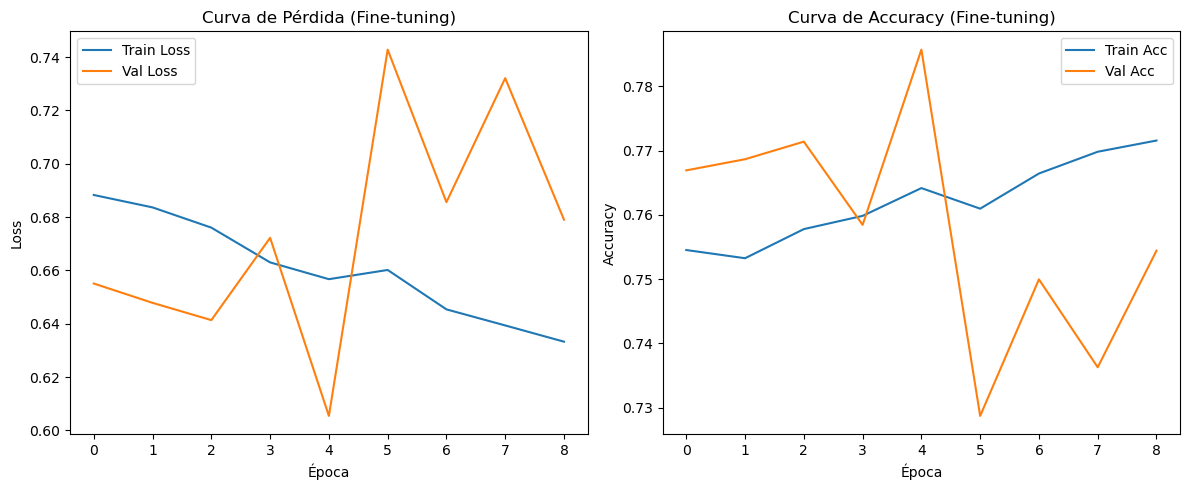

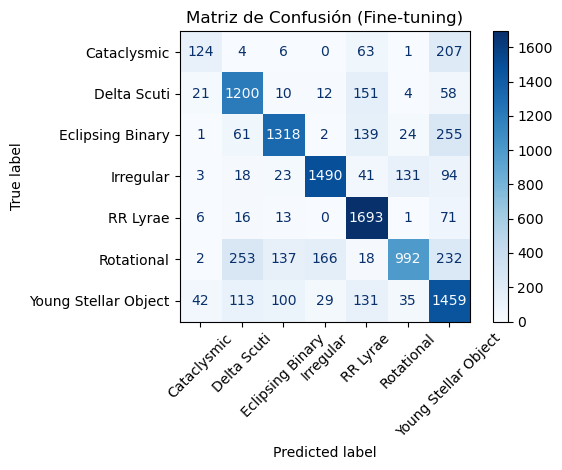

💾 Guardado CSV con errores: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_3_errores_clasificacion.csv
📄 Reporte de clasificación guardado en /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_3_class_report.csv
⚠️ Detected _orig_mod. prefix in state_dict. Stripping prefixes...


/home/ec2-user/SageMaker/astro_transformer/Astroconformer/Astroconformer/Model/Modules/mhsa_pro.py:108: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  cos, sin = RoPE
/home/ec2-user/SageMaker/astro_transformer/Astroconformer/Astroconformer/Model/Modules/mhsa_pro.py:113: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))                 # self-attention: (B, nh, T, hs) * (B, nh, hs, T) -> (B, nh, T, T)


✅ Modelo exportado a ONNX en: /home/ec2-user/SageMaker/astro_transformer/src/fase2/../../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_3.onnx


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/onnx/utils.py:1703: UserWarning: The exported ONNX model failed ONNX shape inference. The model will not be executable by the ONNX Runtime. If this is unintended and you believe there is a bug, please report an issue at https://github.com/pytorch/pytorch/issues. Error reported by strict ONNX shape inference: [ShapeInferenceError] (op_type:Einsum, node name: /pe/Einsum): Inputs has inconsistent type tensor(float) (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380909/work/torch/csrc/jit/serialization/export.cpp:1484.)
  _C._check_onnx_proto(proto)


In [1]:
import torch
from torch.utils.data import DataLoader
import pickle
import os
import torch, gc
import sys
from pathlib import Path
import numpy as np

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_2_transformer_fine_tuning_optimizado import main as fine_tuned_optimized_model

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# acciones para resolver los problemas de memoria
# 1. Liberar memoria
gc.collect()
torch.cuda.empty_cache()

# 2. Optimizar fragmentacion
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.backends.cudnn.benchmark = True

print("🔄 Restaurando datasets...")
train_dataset = torch.load("../data/train/train_dataset.pt")
val_dataset = torch.load("../data/train/val_dataset.pt")

# Cargar datasets completos
print("🔄 Cargando datasets completos...")
train_loader = DataLoader(train_dataset, batch_size=48, shuffle=True, num_workers=12, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=48, shuffle=False, num_workers=12, pin_memory=True, persistent_workers=True)

print(f"Total batches in train_loader: {len(train_loader)}")
print(f"Total batches in val_loader: {len(val_loader)}")

label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"NUM CLASES: {num_classes}")

# Fine-tuning adicional
# Carga desde mejor_modelo_optimizado.pt
# Doble learning rate (encoder / head)
# Descongelado tras las primeras n epocas (freeze_epochs=n) o desde el principio (con freeze_encoder=False)
# Usar scheduler ReduceLROnPlateau
# Optimización por AdamW con weight_decay.
print("🚀 Fine-tuning sobre mejor modelo optimizado...")
model = fine_tuned_optimized_model(
    train_loader=train_loader,
    val_loader=val_loader,
    model_name_in="mejor_modelo_optimizado_YSO_curated_fine_tuned_2.pt",    # <= El generado en el fine tuning anterior
    model_name_out="mejor_modelo_optimizado_YSO_curated_fine_tuned_3.pt",
    label_encoder=label_encoder,
    device=device,
    epochs=10,
    patience=4,
    freeze_encoder=False,
    encoder_lr=2e-6,  # Mismo valor para mantener estabilidad
    head_lr=5e-6,
    gamma=3,
    use_scheduler=True,  # Usar scheduler ReduceLROnPlateau
    scheduler_patience=2  # Menos patience que el EarlyStopping para dar tiempo a que el scheduler pueda actuar
)

#### Resultados del tercer fine-tuning:

**Resumen del tercer ciclo de fine-tuning**:

* **Épocas ejecutadas:** 10 (early stopped en epoch 9)
* **Mejor val\_accuracy alcanzado:** **0.7857**
* **Mejor val\_loss:** **0.6054**
* **Train acc final:** 0.7716
* **Modelo guardado como:** `mejor_modelo_optimizado_YSO_curated_fine_tuned_3.pt`

**Comparativa con ciclo anterior (fine\_tuned\_2)**:

* **Val acc anterior (época 14):** 0.7769
* **Val loss anterior:** 0.6369
* **Matriz de confusión actual:** mejora ligera en clases como:

  * `Young Stellar Object`: ahora 1459 (vs 1444)
  * `RR Lyrae`: 1693 (vs 1676)
  * `Irregular`: 1490 (vs 1463)

**Conclusión**:

Este tercer ciclo ha **mejorado** ligeramente tanto la pérdida de validación como la precisión (especialmente en clases difíciles), y la matriz de confusión muestra un refuerzo en varias clases objetivo sin sobreajuste.

| Clase                | f1-score FT1 | f1-score FT2 | f1-score FT3 |
|----------------------|--------------|--------------|--------------|
| Cataclysmic          | 0.3086       | 0.3517       | 0.3455       |
| Delta Scuti          | 0.6087       | 0.6867       | 0.7067       |
| Eclipsing Binary     | 0.7985       | 0.8206       | 0.8143       |
| Irregular            | 0.7581       | 0.7744       | 0.7876       |
| RR Lyrae             | 0.8295       | 0.8457       | 0.8427       |
| Rotational           | 0.7062       | 0.7386       | 0.7402       |
| Young Stellar Object | 0.7000       | 0.7584       | 0.7492       |
| **Macro avg**        | **0.6735**   | **0.7195**   | **0.7123**   |
| **Weighted avg**     | **0.7097**   | **0.7576**   | **0.7485**   |


=> **el fine-tuned 3 no es mejor que el fine-tuned 2** en términos globales, al menos según los *f1-score*:

### 🔍 Comparativa clave entre FT2 y FT3:

| Métrica               | FT2    | FT3    | Mejor |
| --------------------- | ------ | ------ | ----- |
| **Accuracy val**      | 0.7769 | 0.7857 | FT3 ✅ |
| **f1-score macro**    | 0.7195 | 0.7123 | FT2 ✅ |
| **f1-score weighted** | 0.7576 | 0.7485 | FT2 ✅ |

**Conclusión**:
Aunque el **fine-tuned 3 tiene una *val\_acc* ligeramente superior**, lo que importa en clasificación multiclase desbalanceada como esta es el **f1-score macro** (equilibrio entre clases), y ahí **el fine-tuned 2 es superior**.

* ✅ **Modelo recomendado actual**: `mejor_modelo_optimizado_YSO_curated_fine_tuned_2.pt`
* 🔁 **Conservar FT3** como alternativa si valoramos ligeramente más la *accuracy* general, pero **no es mejor globalmente**.
* 🚫 No es necesario seguir fine-tuneando FT3 salvo que tengas nuevas curvas o un criterio específico que lo justifique.



### 5. **EVALUACIÓN SOBRE DATOS DE TEST**

In [2]:
import torch
from torch.utils.data import DataLoader
import pickle
import os
import gc
import sys
from pathlib import Path
import numpy as np

# Añadir la raíz del proyecto al path
ROOT_DIR = Path.cwd().parent  # <- sube un nivel para alcanzar la raíz del proyecto
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))
from src.fase2.script_3_evaluate_test_final import main as evaluate_test_final

# Detectar dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"

# Liberar memoria y optimizar fragmentación
gc.collect()
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.backends.cudnn.benchmark = True

# Carga dataset
print("🔄 Restaurando dataset de test...")
test_dataset = torch.load("../data/train/test_dataset.pt")
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=12, pin_memory=True, persistent_workers=True)

print(f"Total batches in test_loader: {len(test_loader)}")

# Cargar label_encoder
label_encoder = pickle.load(open("../data/train/label_encoder.pkl", "rb"))
num_classes = len(label_encoder)
print(f"NUM CLASES: {num_classes}")

# Ejecutar evaluación
evaluate_test_final(
    test_loader=test_loader,
    label_encoder=label_encoder,
    model_name_in="../outputs/mejor_modelo_optimizado_YSO_curated_fine_tuned_2.pt",
    output_dir="../outputs/evaluacion_test",
    device=device
)

🔄 Restaurando dataset de test...
Total batches in test_loader: 86
NUM CLASES: 7
⚠️ Detected _orig_mod. prefix in state_dict. Stripping prefixes...
Evaluación completada. Resultados guardados en: ../outputs/evaluacion_test


,precision,recall,f1-score,support
Cataclysmic,0.614679,0.330049,0.429487,203.000000
Delta Scuti,0.733577,0.828297,0.778065,728.000000
Eclipsing Binary,0.820859,0.743333,0.780175,900.000000
Irregular,0.866298,0.871111,0.868698,900.000000
RR Lyrae,0.787097,0.948889,0.860453,900.000000
Rotational,0.843750,0.630000,0.721374,900.000000
Young Stellar Object,0.632653,0.714136,0.670930,955.000000
accuracy,0.770324,0.770324,0.770324,0.770324
macro avg,0.756988,0.723688,0.729883,5486.000000
weighted avg,0.774555,0.770324,0.765947,5486.000000


<Figure size 1000x800 with 0 Axes>